In [1]:
import pandas as pd
from utils import data_wrangling as dw
from utils import ts_wrangling as tw
from utils import plots 
from models import lf_models
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import seaborn as sns
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    CrostonOptimized,
    TSB,
    MSTL,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
)

c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
INIT = "2012-01-01"
END = "2023-02-28"
PERIOD = 24*365
HORIZON = 24*2

# Dados

In [3]:
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
df_load = dw.pipeline(load).loc[INIT:END,:]
df_load = df_load.iloc[-PERIOD:,:]
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-03-01 00:00:00 to 2023-02-28 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_reg      8760 non-null   category
 1   desc_reg    8760 non-null   category
 2   load_mwmed  8760 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 154.4 KB


In [4]:
df_load.describe()

,load_mwmed
count,8760.000000
mean,11641.760189
std,2295.359889
min,5755.558000
25%,9782.649250
50%,11768.670030
75%,13344.280750
max,18345.403000


In [5]:
train, test = tw.train_test_split(df_load, test=HORIZON)

# Modelos

In [23]:
# df_fc = lf_models.auto_arima_model(df=train, h_=HORIZON)
# df_fc.head()

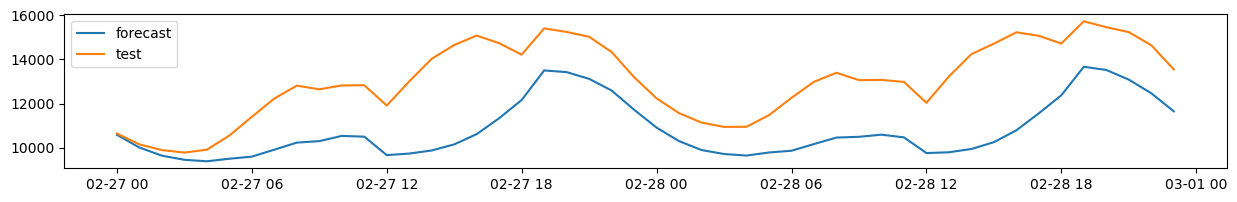

In [36]:
# plt.figure(figsize=(15,2))
# plt.plot(df_fc.ds, df_fc.AutoARIMA, label="forecast")
# plt.plot(test.index, test.load_mwmed, label="test")
# plt.legend()
# plt.show()

# Comparação de modelos

In [6]:
df_sf = dw.prepare_statsforecast_df(train, "hourly_load")

In [7]:
sf, forecasts_df = lf_models.compare_models(df=train, h_=HORIZON, level=[90,95,99])

In [16]:
# forecasts_df_arima = forecasts_df[[x for x in forecasts_df.columns if "ARIMA" in x or "ds" in x]]
# forecasts_df_arima.head()

In [8]:
forecasts_df.head()

,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoARIMA-hi-95,AutoARIMA-hi-99,CrostonClassic,CrostonOptimized,...,AutoETS-hi-95,AutoETS-hi-99,CES,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,AutoTheta-lo-95,AutoTheta-hi-95,AutoTheta-lo-99,AutoTheta-hi-99
unique_id,,,,,,,,,,,,,,,,,,,,,
hourly_load,2023-02-27 00:00:00,10583.355469,9818.888672,10001.667969,10095.188477,11071.523438,11165.043945,11347.823242,10750.967773,11754.276367,...,12614.221680,13011.828125,11460.994141,11335.722656,10354.405273,12573.477539,10263.340820,12612.908203,9873.739258,12827.451172
hourly_load,2023-02-27 01:00:00,10007.152344,8580.058594,8921.267578,9095.849609,10918.455078,11093.037109,11434.246094,10750.967773,11754.276367,...,13162.786133,13726.069336,11423.147461,11335.722656,9852.372070,12884.868164,9511.812500,13044.305664,9174.249023,13708.076172
hourly_load,2023-02-27 02:00:00,9638.824219,7719.761719,8178.598145,8413.363281,10864.285156,11099.050781,11557.886719,10750.967773,11754.276367,...,13590.881836,14281.987305,11376.624023,11335.722656,9185.199219,13169.217773,8942.464844,13455.631836,8699.185547,14012.373047
hourly_load,2023-02-27 03:00:00,9451.693359,7219.575195,7753.261230,8026.324219,10877.062500,11150.125977,11683.811523,10750.967773,11754.276367,...,13956.975586,14756.420898,11337.295898,11335.722656,9159.901367,13208.197266,8853.460938,13802.066406,8025.460938,14847.213867
hourly_load,2023-02-27 04:00:00,9384.501953,6976.620117,7552.330078,7846.894531,10922.108398,11216.672852,11792.382812,10750.967773,11754.276367,...,14283.671875,15179.077148,11292.523438,11335.722656,9096.256836,13600.580078,8364.412109,14128.871094,7620.568848,14514.342773


In [10]:
crossval_df = lf_models.crossval(sf=sf, data=df_sf)
metrics_df, top = lf_models.crossval_summary_table(crossval_df)


In [11]:
metrics_df

,AutoARIMA,CrostonClassic,CrostonOptimized,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,MSTL,AutoETS,CES,AutoTheta,best_model,metric
unique_id,,,,,,,,,,,,
hourly_load,1.652954e+03,2.247784e+03,2.459183e+03,1.410173e+03,1.646164e+03,1.571671e+03,458.485962,1.973990e+03,1.806755e+03,1.855117e+03,MSTL,mean_absolute_error
hourly_load,3.841199e+06,6.134624e+06,7.393277e+06,2.976568e+06,3.555754e+06,3.668218e+06,308453.468750,4.823229e+06,3.739583e+06,4.175892e+06,MSTL,mean_squared_error
hourly_load,3.841199e+06,6.134624e+06,7.393277e+06,2.976568e+06,3.555754e+06,3.668218e+06,308453.468750,4.823229e+06,3.739583e+06,4.175892e+06,MSTL,mean_squared_error
hourly_load,1.676916e-01,2.295654e-01,2.527711e-01,1.408378e-01,1.695073e-01,1.583805e-01,0.044464,2.032261e-01,1.810998e-01,1.897660e-01,MSTL,mean_absolute_percentage_error
hourly_load,-1.179998e+00,-2.511303e+00,-3.132295e+00,-8.618599e-01,-7.641998e-01,-1.009915e+00,0.833807,-1.643322e+00,-1.030364e+00,-1.278093e+00,CrostonOptimized,r2_score
hourly_load,1.494434e-01,2.011608e-01,2.180046e-01,1.275014e-01,1.534643e-01,1.410429e-01,0.045788,1.800134e-01,1.667923e-01,1.704277e-01,MSTL,MeanAbsolutePercentageError


In [12]:
top # MELHOR MODELO: MSTL

,0
best_model,
CrostonOptimized,1
MSTL,5


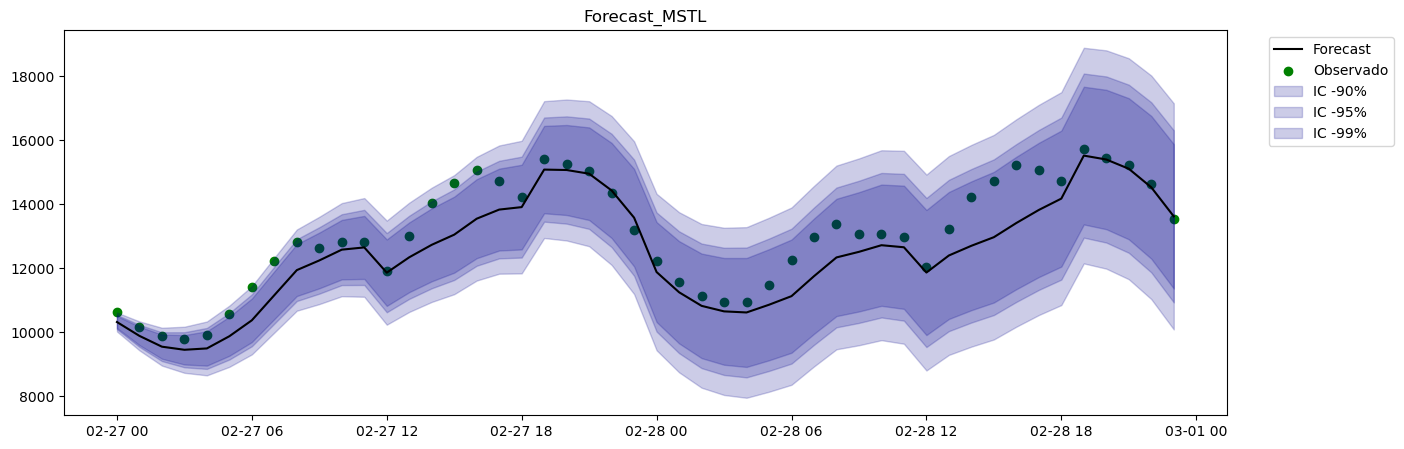

In [21]:
MSTL_fcs = tw.extract_model_cols(forecasts_df, "MSTL")
plots.plot_with_confidence(data=MSTL_fcs, x_="ds", y_="MSTL", levels=[90,95,99], test=test["load_mwmed"], title_=f"Forecast_MSTL", save=True)

In [20]:
fcs_path = "fcs_data/"
forecasts_df.to_excel(''.join([fcs_path,"forecasts_df.xlsx"]))
metrics_df.to_excel(''.join([fcs_path,"metrics_df.xlsx"]))